PyTorch Gentle Introduction
=====

We'll be working with PyTorch today, so let's begin importing it!

In [ ]:
import torch

print(torch.__version__)

1.10.0+cu111


## Tensors

Tensors are the building blocks of PyTorch. There are many ways to construct them. Can you find out what these 4 constructions do?

In [ ]:
x1 = torch.rand(4, 5)
x2 = torch.randn(5, 7)
x3 = torch.zeros(5, 6)
x4 = torch.ones(6, 7)

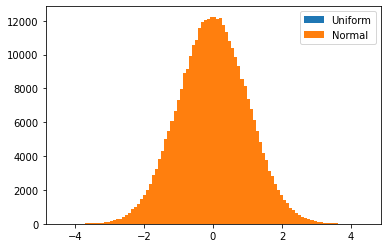

In [ ]:
import matplotlib.pyplot as plt


plt.hist(x1.flatten().numpy(), bins=100, label="Uniform")
plt.hist(x2.flatten().numpy(), bins=100, label="Normal")
plt.legend()
plt.show()

Tensors can be multiplied together. Can you find out what the result of this multiplication is?


In [ ]:
# broadcasting

points = torch.rand(100, 2)  # 100 points in dimension 2
center = torch.rand(2)       # 1 point in dimension 2

# all distances between the points and the center?
distances_naive = []
for i in range(points.size(0)):
  distance = (points[i] - center).norm()
  distances_naive.append(distance)

points.size(), center.size()

distances_optimize = (points - center).norm(dim=1)

distances_naive[:10], distances_optimize[:10]

([tensor(0.5290),
  tensor(0.7043),
  tensor(0.7662),
  tensor(0.4830),
  tensor(0.8990),
  tensor(0.5041),
  tensor(0.2543),
  tensor(0.3277),
  tensor(0.2467),
  tensor(0.5374)],
 tensor([0.5290, 0.7043, 0.7662, 0.4830, 0.8990, 0.5041, 0.2543, 0.3277, 0.2467,
         0.5374]))

In [ ]:
list(range(points.size(0)))


Tensor manipulation is extremely important in PyTorch as soon as you want to construct more elaborate tensors. Can you find three ways of constructing the identity matrix of size 5 by 5 (zeros everywhere and ones in the main diagonal)?

In [ ]:
# using built-in eye function
eye = torch.eye(5)
print(eye)

# using a for loop 
eye = torch.zeros(5, 5)
for i in range(5):
  eye[i, i] = 1

# using torch.Tensor constructor
eye = torch.Tensor([
        [1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.]])

tensor([[1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.]])


## Modules

A Module is the core component of a neural network. It implements a forward pass and autograd takes care of the backward pass. Let's see how it works!

In [ ]:
import torch.nn as nn


batch_size = 4
in_features = 6
out_features = 3

model = nn.Linear(in_features, out_features, bias=True)
x = torch.rand(batch_size, in_features)

# forward pass
y = model(x)  
print(y.size())

# can you figure out what is the size of y? Why?
weight = model.weight.data
bias = model.bias.data

y_hand = x.mm(weight.t()) + bias
torch.allclose(y, y_hand)

torch.Size([4, 3])


True

In [ ]:
weight.size(), bias.size(), x.size()

(torch.Size([3, 6]), torch.Size([3]), torch.Size([4, 6]))

Can you recover the same result by implementing the linear layer by hand?

Now let's define a very simple neural network!

In [ ]:
import torch.nn as nn


model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 500),
    nn.ReLU(),
    nn.Linear(500, 250),
    nn.ReLU(),  
    nn.Linear(250, 10),
)

img = torch.rand(16, 1, 28, 28) # image size (3, 224, 224)
model[0](img).size()  # forward img through model[0] = Flatten()

torch.Size([16, 784])

In [ ]:
torch.rand(1, 5, 3, 1, 56).squeeze().size()

torch.Size([5, 3, 56])

## Dataset & Dataloader

Let's load the MNIST training and test data and display a couple of images.

In [ ]:
from torchvision import datasets
from torchvision.transforms import ToTensor


training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [ ]:
training_data[245][1]  # what does it contain?

8

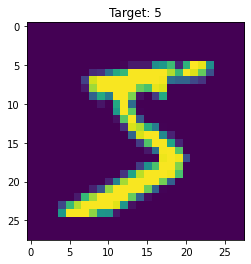

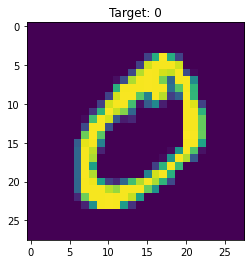

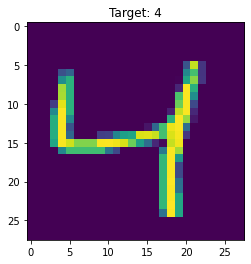

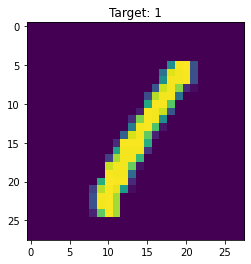

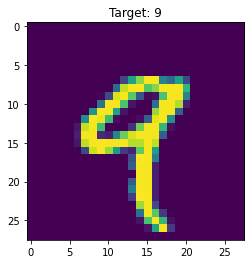

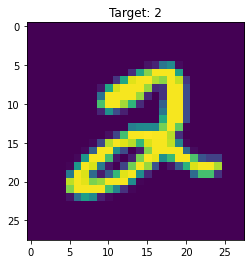

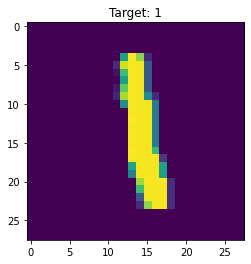

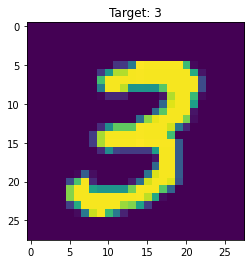

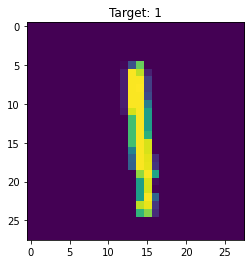

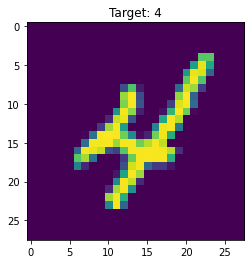

In [ ]:
import matplotlib.pyplot as plt

for idx in range(10):
  img, target = training_data[idx]  # tuple unpacking
  plt.imshow(img.squeeze())
  plt.title(f"Target: {target}")
  plt.show()

Now let's define a dataloader that will batch the data together! By the way, do you know why we batch data?

In [ ]:
train_loader =  torch.utils.data.DataLoader (
    training_data, 
    shuffle=True,
    batch_size=16
)

test_loader =  torch.utils.data.DataLoader (
    test_data, 
    shuffle=True,
    batch_size=16
)

### Training Loop


In [ ]:
import numpy as np


device =  torch.device("cpu")  # 
criteria = nn.CrossEntropyLoss()  # what is this?
lr = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
# how many classes do we have?
losses = []
# how many epochs I am doing in my training loop?
# is it enough to perform 1 epoch?
for idx, (imgs, targets) in enumerate(train_loader):
  imgs = imgs.to(device)
  targets = targets.to(device)
  output = model(imgs)  # same as model.forward(images)
  # if the network is random, what would be the average value of the loss?
  # ln(probability of any class if the network is random) = -ln(0.1)

  loss = criteria(output, targets)
  losses.append(loss.item())
  loss.backward()  # will populate the .grad attribute of each parameter
  optimizer.zero_grad()  # what happens if I do this? -> no gradient anymore
  optimizer.step()

  if idx % 1000 == 0:
    print(f"Loss: {np.mean(losses):.2f}")
    losses = []

Loss: 0.13
Loss: 0.27
Loss: 0.26
Loss: 0.25


In [ ]:
# Let's take 10 min to 
# - modify the code to do many traning epochs
# - increase model size 
# - play with the learning rate
# - change the device to cuda
# Goal: have the best *TEST* accurracy

In [ ]:
correct = 0

for idx, (imgs, targets) in enumerate(test_loader):
  imgs = imgs.to(device)
  targets = targets.to(device)
  output = model(imgs)
  pred = output.argmax()

  correct += pred.eq(targets).sum()

print(correct)

tensor(107)
